In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Amazonas - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_AM.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amazonas - Consumo de Cimento (t),Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,28.193,0.695898,0.330279,8.630942,51.313080,0.694618,0.658468,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,11283.694800,0.745671,1.284537e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,31.226,0.696043,0.331137,8.624872,51.554195,0.694427,0.658814,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,11377.134800,0.745986,1.291713e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,33.484,0.696187,0.331306,8.618803,51.523306,0.694236,0.659160,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,11466.977022,0.746301,1.298888e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,31.596,0.696332,0.331791,8.612734,51.639628,0.694045,0.659506,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,11551.599522,0.746616,1.306063e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,32.919,0.696476,0.332189,8.606665,51.838456,0.693854,0.659852,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,11632.378833,0.746931,1.313239e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37456.010239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37394.661846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37304.892245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37191.083011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


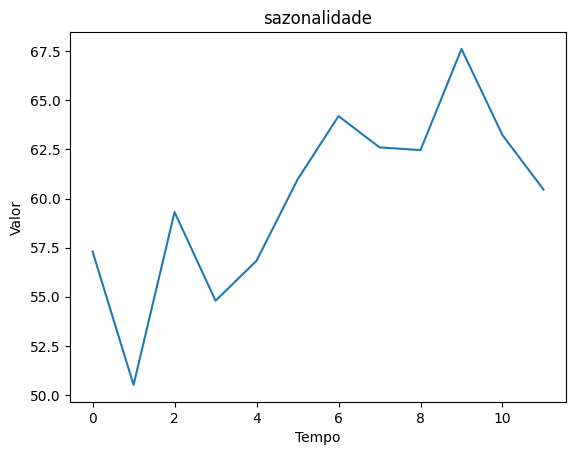

,sazonalidade
sazonalidade,
0,57.301925
1,50.512386
2,59.312410
3,54.797900
4,56.835213
5,60.968302
6,64.197858
7,62.603844
8,62.465818


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amazonas - IDH,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Per Capita,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Amazonas - Consumo de Cimento (t)
0,2003-1,0.695898,0.330279,8.630942,51.313080,0.694618,0.658468,4.754469e+07,2.519796e+06,12.490621,4.318518e+07,11283.694800,0.745671,1.284537e+06,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,57.301925,28.193
1,2003-2,0.696043,0.331137,8.624872,51.554195,0.694427,0.658814,4.760190e+07,2.521321e+06,12.492164,4.320154e+07,11377.134800,0.745986,1.291713e+06,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,50.512386,31.226
2,2003-3,0.696187,0.331306,8.618803,51.523306,0.694236,0.659160,4.765911e+07,2.522846e+06,12.493707,4.321789e+07,11466.977022,0.746301,1.298888e+06,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,59.312410,33.484
3,2003-4,0.696332,0.331791,8.612734,51.639628,0.694045,0.659506,4.771632e+07,2.524370e+06,12.495250,4.323425e+07,11551.599522,0.746616,1.306063e+06,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,54.797900,31.596
4,2003-5,0.696476,0.332189,8.606665,51.838456,0.693854,0.659852,4.777353e+07,2.525895e+06,12.496793,4.325060e+07,11632.378833,0.746931,1.313239e+06,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,56.835213,32.919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37456.010239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.835213,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37394.661846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.968302,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37304.892245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.197858,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37191.083011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.603844,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      39.696
1      56.005
2      39.376
3      59.327
4      40.816
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Amazonas - Consumo de Cimento (t), Length: 249, dtype: float64

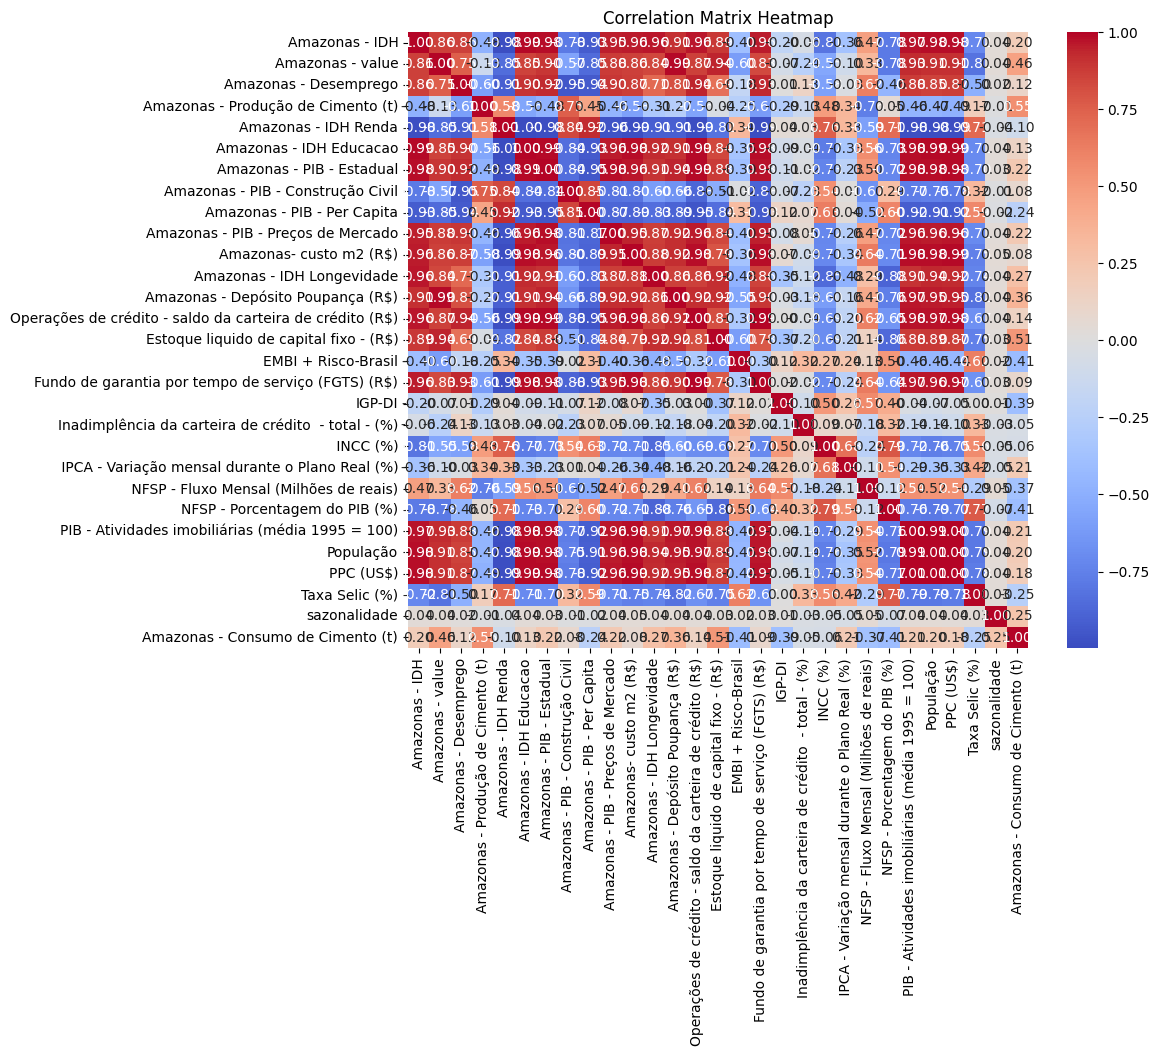

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Amazonas - IDH,1.983526e+09
1,Amazonas - value,7.190737e+04
2,Amazonas - Desemprego,5.668509e+04
3,Amazonas - Produção de Cimento (t),3.197684e+04
4,Amazonas - IDH Renda,2.100728e+08
5,Amazonas - IDH Educacao,1.053538e+09
6,Amazonas - PIB - Estadual,5.990764e+07
7,Amazonas - PIB - Construção Civil,5.379216e+06
8,Amazonas - PIB - Per Capita,7.108119e+08
9,Amazonas - PIB - Preços de Mercado,5.649714e+08


In [39]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 2


,Amazonas - value,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.330279,8.630942,51.313080,0.694618,0.658468,4.754469e+07,2.519796e+06,4.318518e+07,11283.694800,0.745671,1.284537e+06,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,57.301925
1,0.331137,8.624872,51.554195,0.694427,0.658814,4.760190e+07,2.521321e+06,4.320154e+07,11377.134800,0.745986,1.291713e+06,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,50.512386
2,0.331306,8.618803,51.523306,0.694236,0.659160,4.765911e+07,2.522846e+06,4.321789e+07,11466.977022,0.746301,1.298888e+06,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,59.312410
3,0.331791,8.612734,51.639628,0.694045,0.659506,4.771632e+07,2.524370e+06,4.323425e+07,11551.599522,0.746616,1.306063e+06,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,54.797900
4,0.332189,8.606665,51.838456,0.693854,0.659852,4.777353e+07,2.525895e+06,4.325060e+07,11632.378833,0.746931,1.313239e+06,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,56.835213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.609257,12.496896,39.455544,0.657507,0.714781,5.524407e+07,2.468741e+06,4.423016e+07,27473.767449,0.764289,3.379518e+06,3.339533e+06,7.711687e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,2.005841e+08,437.906135,0.516394,62.603844
200,0.615435,12.485572,39.180490,0.657525,0.714636,5.519348e+07,2.470217e+06,4.422131e+07,27692.600768,0.764089,3.431273e+06,3.365687e+06,7.707969e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,2.006695e+08,438.554287,0.509923,62.465818
201,0.622117,12.474248,39.694776,0.657543,0.714491,5.514289e+07,2.471693e+06,4.421245e+07,27908.194631,0.763890,3.483028e+06,3.396904e+06,7.704251e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,2.007550e+08,439.156241,0.467083,67.616651
202,0.628539,12.462925,39.866004,0.657561,0.714345,5.509231e+07,2.473169e+06,4.420359e+07,28134.319863,0.763691,3.534783e+06,3.425371e+06,7.700533e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,2.008405e+08,439.704663,0.441494,63.228792


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,0.052061,0.577216,1.000000,0.000000,0.000000,0.613647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108706,0.014287,0.803606,0.790380,1.000000,1.000000,0.301039,1.000000,0.000000,0.000000,0.000000,0.827406
1,0.050819,0.585070,0.994872,0.005888,0.006887,0.624331,0.014567,0.005468,0.012908,0.003117,0.000190,0.011007,0.058377,0.004635,0.752660,0.788742,0.968938,0.921240,0.301792,0.966038,0.001495,0.007652,0.003428,0.719915
2,0.049577,0.584064,0.989745,0.011777,0.013774,0.635015,0.029134,0.010726,0.025815,0.006234,0.000203,0.022015,0.100305,0.000909,0.728503,0.788333,0.948438,0.873107,0.294922,0.928087,0.002989,0.015303,0.006967,1.000000
3,0.048335,0.587853,0.984617,0.017665,0.020662,0.645699,0.043701,0.015678,0.038723,0.009351,0.000349,0.033022,0.211591,0.000000,0.690036,0.787696,0.928794,0.851659,0.279215,0.886653,0.004484,0.022955,0.010587,0.656464
4,0.047093,0.594330,0.979489,0.023553,0.027549,0.656383,0.058268,0.020405,0.051630,0.012468,0.000809,0.044030,0.358835,0.002131,0.662845,0.784532,0.970421,0.823277,0.285466,0.839542,0.006327,0.030606,0.014112,0.810086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.843123,0.190951,0.003390,0.958146,0.926866,0.255870,0.930765,0.947438,0.763087,0.910069,0.964083,0.749512,0.164662,0.843595,0.925754,0.200335,0.437606,0.269755,0.988898,0.004294,0.987846,0.985587,0.991307,0.096760
200,0.840806,0.181991,0.003875,0.955671,0.920777,0.266214,0.922875,0.960245,0.754916,0.932552,0.972616,0.742205,0.166152,0.841613,0.940916,0.197374,0.449028,0.321896,0.989787,0.001943,0.990212,0.989191,0.993698,0.092442
201,0.838489,0.198744,0.004359,0.953196,0.914687,0.276558,0.914985,0.972861,0.746744,0.955035,0.982801,0.734899,0.171580,0.899079,0.983770,0.173835,0.471116,0.386916,0.966651,0.001563,0.992579,0.992794,0.995919,0.063859
202,0.836172,0.204322,0.004843,0.950721,0.908597,0.286902,0.907094,0.986094,0.738573,0.977517,0.992089,0.727592,0.177868,0.970196,0.973718,0.162834,0.496672,0.432519,0.988004,0.001600,0.996289,0.996397,0.997943,0.046786


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,0.052061,0.577216,1.000000,0.000000,0.000000,0.613647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108706,0.014287,0.803606,0.790380,1.000000,1.000000,0.301039,1.000000,0.000000,0.000000,0.000000,0.827406
1,0.050819,0.585070,0.994872,0.005888,0.006887,0.624331,0.014567,0.005468,0.012908,0.003117,0.000190,0.011007,0.058377,0.004635,0.752660,0.788742,0.968938,0.921240,0.301792,0.966038,0.001495,0.007652,0.003428,0.719915
2,0.049577,0.584064,0.989745,0.011777,0.013774,0.635015,0.029134,0.010726,0.025815,0.006234,0.000203,0.022015,0.100305,0.000909,0.728503,0.788333,0.948438,0.873107,0.294922,0.928087,0.002989,0.015303,0.006967,1.000000
3,0.048335,0.587853,0.984617,0.017665,0.020662,0.645699,0.043701,0.015678,0.038723,0.009351,0.000349,0.033022,0.211591,0.000000,0.690036,0.787696,0.928794,0.851659,0.279215,0.886653,0.004484,0.022955,0.010587,0.656464
4,0.047093,0.594330,0.979489,0.023553,0.027549,0.656383,0.058268,0.020405,0.051630,0.012468,0.000809,0.044030,0.358835,0.002131,0.662845,0.784532,0.970421,0.823277,0.285466,0.839542,0.006327,0.030606,0.014112,0.810086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.866685,0.088348,0.013632,0.976179,0.982205,0.133165,0.991832,0.839306,0.853471,0.752690,0.905889,0.828698,0.187214,0.772088,0.306496,0.228511,0.005731,0.000000,0.770932,0.039832,0.940133,0.945526,0.954021,0.142213
188,0.865216,0.100096,0.010905,0.976037,0.979663,0.143224,0.990665,0.846096,0.846834,0.752690,0.910701,0.823090,0.197767,0.765287,0.374969,0.204051,0.037761,0.029504,0.843110,0.036772,0.946259,0.948494,0.957505,0.121167
189,0.863748,0.110341,0.008179,0.975895,0.977121,0.153284,0.989498,0.852969,0.840198,0.752690,0.918025,0.817482,0.203626,0.822408,0.426663,0.163703,0.087044,0.043125,0.852836,0.032169,0.952386,0.951462,0.960752,0.085226
190,0.862280,0.121334,0.005453,0.975753,0.974579,0.163343,0.988332,0.860533,0.833561,0.752690,0.924362,0.811875,0.204541,0.894295,0.491223,0.131737,0.118264,0.059756,0.901189,0.026694,0.956511,0.954429,0.963720,0.124421


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      39.696
1      56.005
2      39.376
3      59.327
4      40.816
        ...  
187    62.126
188    67.521
189    61.319
190    55.832
191    52.499
Name: Amazonas - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 24)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Amazonas - Desemprego,Amazonas - Produção de Cimento (t),Amazonas - IDH Renda,Amazonas - IDH Educacao,Amazonas - PIB - Estadual,Amazonas - PIB - Construção Civil,Amazonas - PIB - Preços de Mercado,Amazonas- custo m2 (R$),Amazonas - IDH Longevidade,Amazonas - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
156,1.000000,0.448670,0.055510,0.982643,0.972118,0.031203,0.874406,0.686970,1.000000,0.602101,0.916170,0.960324,0.442089,0.839309,0.068901,0.587637,0.194855,0.431209,0.413661,0.036321,0.809361,0.849576,0.841791,0.468318
157,0.992455,0.422086,0.052753,0.984090,0.974040,0.028603,0.880428,0.690641,0.996606,0.609803,0.912459,0.956993,0.467381,0.801704,0.032121,0.643262,0.182507,0.379453,0.455637,0.033116,0.809984,0.852720,0.845267,0.411842
158,0.984909,0.399922,0.049996,0.985536,0.975961,0.026003,0.886450,0.694082,0.993211,0.617504,0.908995,0.953662,0.483414,0.790541,0.022138,0.709146,0.168812,0.332832,0.444532,0.030640,0.810608,0.855864,0.849072,0.445079
159,0.977364,0.378842,0.047239,0.986982,0.977883,0.023403,0.892473,0.697577,0.989817,0.625206,0.905562,0.950331,0.485402,0.775928,0.029764,0.729647,0.152959,0.313954,0.426520,0.028514,0.811231,0.859008,0.852964,0.424429
160,0.969819,0.359110,0.044481,0.988429,0.979804,0.020802,0.898495,0.701216,0.986423,0.632907,0.902608,0.947000,0.480289,0.772954,0.056928,0.729821,0.137613,0.294856,0.443124,0.026816,0.811034,0.862152,0.856928,0.481307
161,0.962274,0.340394,0.041724,0.989875,0.981726,0.018202,0.904517,0.704999,0.983028,0.640608,0.899226,0.943668,0.466293,0.770874,0.061888,0.716852,0.163171,0.308016,0.437764,0.025008,0.810837,0.865295,0.860686,0.545277
162,0.954728,0.321719,0.038967,0.991322,0.983648,0.015602,0.910540,0.708694,0.979634,0.648310,0.896766,0.940337,0.446692,0.763405,0.028761,0.746600,0.115114,0.297600,0.424379,0.024308,0.810640,0.868439,0.864433,0.411731
163,0.947183,0.304802,0.036210,0.992768,0.985569,0.013001,0.916562,0.712585,0.976239,0.656011,0.894216,0.937006,0.423280,0.760489,0.049338,0.803166,0.099148,0.258616,0.427657,0.024210,0.813009,0.871583,0.868468,0.517393
164,0.939638,0.289312,0.033453,0.994214,0.987491,0.010401,0.922584,0.717355,0.972845,0.663713,0.892500,0.933675,0.387661,0.754812,0.076797,0.850835,0.092609,0.249254,0.410864,0.025786,0.815379,0.874727,0.872546,0.484026
165,0.932093,0.273134,0.030696,0.995661,0.989412,0.007801,0.928606,0.722307,0.969451,0.671414,0.891376,0.930344,0.351781,0.801517,0.077481,0.875483,0.088481,0.255443,0.380278,0.027984,0.817748,0.877871,0.876542,0.460061


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.2,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2079161913, 3249587428, 1022277802, 992843036, 3791328852, 2160103019, 882533586, 1535016583, 3338613016, 1034485429]


Step: 0 ___________________________________________
val_loss: 103.30494689941406
winner_seed: 2079161913


Step: 1 ___________________________________________
val_loss: 55.8012809753418
winner_seed: 3249587428


Step: 2 ___________________________________________
val_loss: 50.909908294677734
winner_seed: 1022277802


Step: 3 ___________________________________________
val_loss: 247.9864501953125


Step: 4 ___________________________________________
val_loss: 53.905372619628906


Step: 5 ___________________________________________
val_loss: 52.403648376464844


Step: 6 ___________________________________________
val_loss: 41.67066192626953
winner_seed: 882533586


Step: 7 ___________________________________________
val_loss: 85.17697143554688


Step: 8 ___________________________________________
val_loss: 51.80957794189453


Step: 9 ___________________________________

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 282560761

Epoch 1/10000
4/4 [==============================] - 2s 142ms/step - loss: 3538.7280 - val_loss: 300.9086
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 323.6181 - val_loss: 622.1928
Epoch 3/10000
4/4 [==============================] - 0s 13ms/step - loss: 272.4097 - val_loss: 785.5676
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 272.0326 - val_loss: 703.7103
Epoch 5/10000
4/4 [==============================] - 0s 10ms/step - loss: 278.9083 - val_loss: 679.8424
Epoch 6/10000
4/4 [==============================] - 0s 10ms/step - loss: 277.8928 - val_loss: 684.2479
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 276.5193 - val_loss: 667.4485
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 283.9331 - val_loss: 636.4080
Epoch 9/10000
4/4 [==============================] - 0s 11ms/step - loss: 272.8268 - val_loss: 820.7828
Epoch 10/10000
4/4 [==============================] - 0s 11ms/

4/4 [==============================] - 0s 11ms/step - loss: 182.6434 - val_loss: 161.3373
Epoch 80/10000
4/4 [==============================] - 0s 10ms/step - loss: 211.3004 - val_loss: 164.4803
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 188.8452 - val_loss: 135.0727
Epoch 82/10000
4/4 [==============================] - 0s 10ms/step - loss: 205.0723 - val_loss: 134.4473
Epoch 83/10000
4/4 [==============================] - 0s 11ms/step - loss: 199.5131 - val_loss: 140.2518
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 190.4477 - val_loss: 200.5085
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 209.2643 - val_loss: 163.3316
Epoch 86/10000
4/4 [==============================] - 0s 12ms/step - loss: 187.2193 - val_loss: 157.9149
Epoch 87/10000
4/4 [==============================] - 0s 10ms/step - loss: 183.0716 - val_loss: 183.1589
Epoch 88/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 135.4314 - val_loss: 194.5296
Epoch 157/10000
4/4 [==============================] - 0s 11ms/step - loss: 141.8288 - val_loss: 156.8176
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 135.5299 - val_loss: 206.8346
Epoch 159/10000
4/4 [==============================] - 0s 10ms/step - loss: 147.1917 - val_loss: 187.1697
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 133.8490 - val_loss: 149.3319
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 133.6475 - val_loss: 173.1151
Epoch 162/10000
4/4 [==============================] - 0s 11ms/step - loss: 151.0975 - val_loss: 143.4183
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 138.7082 - val_loss: 160.3557
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 131.3661 - val_loss: 131.9433
Epoch 165/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 11ms/step - loss: 133.2708 - val_loss: 122.9468
Epoch 234/10000
4/4 [==============================] - 0s 10ms/step - loss: 134.9867 - val_loss: 134.6381
Epoch 235/10000
4/4 [==============================] - 0s 11ms/step - loss: 126.2965 - val_loss: 133.6928
Epoch 236/10000
4/4 [==============================] - 0s 12ms/step - loss: 124.3710 - val_loss: 149.6134
Epoch 237/10000
4/4 [==============================] - 0s 11ms/step - loss: 145.8047 - val_loss: 144.3741
Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 136.3788 - val_loss: 122.1146
Epoch 239/10000
4/4 [==============================] - 0s 11ms/step - loss: 129.5051 - val_loss: 112.6601
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 126.4466 - val_loss: 133.7741
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 159.5037 - val_loss: 151.9663
Epoch 242/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 10ms/step - loss: 128.4672 - val_loss: 817.1002
Epoch 311/10000
4/4 [==============================] - 0s 11ms/step - loss: 117.4015 - val_loss: 271.6566
Epoch 312/10000
4/4 [==============================] - 0s 11ms/step - loss: 134.1547 - val_loss: 113.2886
Epoch 313/10000
4/4 [==============================] - 0s 12ms/step - loss: 130.3626 - val_loss: 359.5503
Epoch 314/10000
4/4 [==============================] - 0s 10ms/step - loss: 119.5900 - val_loss: 750.9601
Epoch 315/10000
4/4 [==============================] - 0s 11ms/step - loss: 133.8119 - val_loss: 927.6322
Epoch 316/10000
4/4 [==============================] - 0s 10ms/step - loss: 120.7294 - val_loss: 712.0510
Epoch 317/10000
4/4 [==============================] - 0s 9ms/step - loss: 117.8123 - val_loss: 872.3001
Epoch 318/10000
4/4 [==============================] - 0s 11ms/step - loss: 138.7909 - val_loss: 695.7479
Epoch 319/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 12ms/step - loss: 127.8166 - val_loss: 183.7693
Epoch 388/10000
4/4 [==============================] - 0s 10ms/step - loss: 118.8668 - val_loss: 622.0674
Epoch 389/10000
4/4 [==============================] - 0s 11ms/step - loss: 120.4473 - val_loss: 615.6676
Epoch 390/10000
4/4 [==============================] - 0s 10ms/step - loss: 138.6434 - val_loss: 273.4056
Epoch 391/10000
4/4 [==============================] - 0s 9ms/step - loss: 119.9012 - val_loss: 558.9615
Epoch 392/10000
4/4 [==============================] - 0s 11ms/step - loss: 117.8295 - val_loss: 705.0086
Epoch 393/10000
4/4 [==============================] - 0s 12ms/step - loss: 125.6696 - val_loss: 589.2440
Epoch 394/10000
4/4 [==============================] - 0s 12ms/step - loss: 125.5420 - val_loss: 142.6163
Epoch 395/10000
4/4 [==============================] - 0s 12ms/step - loss: 113.2718 - val_loss: 818.7367
Epoch 396/10000
4/4 [==============================] - 0s 12ms/

Epoch 465/10000
4/4 [==============================] - 0s 9ms/step - loss: 124.3783 - val_loss: 533.6898
Epoch 466/10000
4/4 [==============================] - 0s 9ms/step - loss: 130.4987 - val_loss: 970.2397
Epoch 467/10000
4/4 [==============================] - 0s 9ms/step - loss: 135.9522 - val_loss: 283.9958
Epoch 468/10000
4/4 [==============================] - 0s 10ms/step - loss: 133.2596 - val_loss: 813.9692
Epoch 469/10000
4/4 [==============================] - 0s 10ms/step - loss: 131.8907 - val_loss: 909.6128
Epoch 470/10000
4/4 [==============================] - 0s 9ms/step - loss: 120.9851 - val_loss: 600.8320
Epoch 471/10000
4/4 [==============================] - 0s 9ms/step - loss: 120.8417 - val_loss: 408.6456
Epoch 472/10000
4/4 [==============================] - 0s 8ms/step - loss: 117.7471 - val_loss: 901.4994
Epoch 473/10000
4/4 [==============================] - 0s 9ms/step - loss: 123.6943 - val_loss: 408.7126
Epoch 474/10000
4/4 [==============================] 

Epoch 543/10000
4/4 [==============================] - 0s 9ms/step - loss: 117.6969 - val_loss: 421.0303
Epoch 544/10000
4/4 [==============================] - 0s 8ms/step - loss: 111.3273 - val_loss: 276.3546
Epoch 545/10000
4/4 [==============================] - 0s 8ms/step - loss: 115.9685 - val_loss: 387.1600
Epoch 546/10000
4/4 [==============================] - 0s 8ms/step - loss: 114.9208 - val_loss: 350.8817
Epoch 547/10000
4/4 [==============================] - 0s 9ms/step - loss: 112.0693 - val_loss: 513.1730
Epoch 548/10000
4/4 [==============================] - 0s 8ms/step - loss: 131.0830 - val_loss: 411.2422
Epoch 549/10000
4/4 [==============================] - 0s 8ms/step - loss: 131.3234 - val_loss: 532.7610
Epoch 550/10000
4/4 [==============================] - 0s 8ms/step - loss: 122.0293 - val_loss: 348.2707
Epoch 551/10000
4/4 [==============================] - 0s 8ms/step - loss: 127.5966 - val_loss: 385.6101
Epoch 552/10000
4/4 [==============================] - 

4/4 [==============================] - 0s 7ms/step - loss: 109.1821 - val_loss: 365.6154
Epoch 622/10000
4/4 [==============================] - 0s 7ms/step - loss: 123.9661 - val_loss: 425.8549
Epoch 623/10000
4/4 [==============================] - 0s 7ms/step - loss: 135.3184 - val_loss: 398.3809
Epoch 624/10000
4/4 [==============================] - 0s 7ms/step - loss: 118.7743 - val_loss: 441.4591
Epoch 625/10000
4/4 [==============================] - 0s 7ms/step - loss: 115.4643 - val_loss: 343.4122
Epoch 626/10000
4/4 [==============================] - 0s 7ms/step - loss: 113.6602 - val_loss: 326.5521
Epoch 627/10000
4/4 [==============================] - 0s 7ms/step - loss: 111.1674 - val_loss: 410.1750
Epoch 628/10000
4/4 [==============================] - 0s 7ms/step - loss: 111.3841 - val_loss: 328.8689
Epoch 629/10000
4/4 [==============================] - 0s 7ms/step - loss: 135.1343 - val_loss: 507.8432
Epoch 630/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 9ms/step - loss: 123.6263 - val_loss: 308.9582
Epoch 700/10000
4/4 [==============================] - 0s 8ms/step - loss: 118.6618 - val_loss: 288.3299
Epoch 701/10000
4/4 [==============================] - 0s 8ms/step - loss: 119.7786 - val_loss: 317.4168
Epoch 702/10000
4/4 [==============================] - 0s 8ms/step - loss: 111.3904 - val_loss: 421.8165
Epoch 703/10000
4/4 [==============================] - 0s 8ms/step - loss: 117.3115 - val_loss: 403.6187
Epoch 704/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.6201 - val_loss: 388.8631
Epoch 705/10000
4/4 [==============================] - 0s 9ms/step - loss: 122.6659 - val_loss: 393.2306
Epoch 706/10000
4/4 [==============================] - 0s 9ms/step - loss: 110.1648 - val_loss: 318.8080
Epoch 707/10000
4/4 [==============================] - 0s 9ms/step - loss: 113.1059 - val_loss: 438.3701
Epoch 708/10000
4/4 [==============================] - 0s 11ms/step - l

4/4 [==============================] - 0s 9ms/step - loss: 118.8773 - val_loss: 377.3448
Epoch 778/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.9286 - val_loss: 387.3924
Epoch 779/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.9361 - val_loss: 377.5696
Epoch 780/10000
4/4 [==============================] - 0s 9ms/step - loss: 105.1277 - val_loss: 399.7772
Epoch 781/10000
4/4 [==============================] - 0s 8ms/step - loss: 117.0734 - val_loss: 404.7767
Epoch 782/10000
4/4 [==============================] - 0s 8ms/step - loss: 110.6526 - val_loss: 351.7580
Epoch 783/10000
4/4 [==============================] - 0s 8ms/step - loss: 115.9036 - val_loss: 353.7484
Epoch 784/10000
4/4 [==============================] - 0s 8ms/step - loss: 105.9847 - val_loss: 378.3606
Epoch 785/10000
4/4 [==============================] - 0s 9ms/step - loss: 116.1842 - val_loss: 362.8784
Epoch 786/10000
4/4 [==============================] - 0s 8ms/step - lo

4/4 [==============================] - 0s 8ms/step - loss: 116.1538 - val_loss: 325.4201
Epoch 856/10000
4/4 [==============================] - 0s 8ms/step - loss: 122.0358 - val_loss: 300.1138
Epoch 857/10000
4/4 [==============================] - 0s 8ms/step - loss: 115.2762 - val_loss: 283.8232
Epoch 858/10000
4/4 [==============================] - 0s 8ms/step - loss: 124.0638 - val_loss: 286.0082
Epoch 859/10000
4/4 [==============================] - 0s 9ms/step - loss: 115.8354 - val_loss: 287.3922
Epoch 860/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.7636 - val_loss: 305.6739
Epoch 861/10000
4/4 [==============================] - 0s 10ms/step - loss: 117.8160 - val_loss: 297.3412
Epoch 862/10000
4/4 [==============================] - 0s 9ms/step - loss: 120.9624 - val_loss: 264.1226
Epoch 863/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.3858 - val_loss: 299.2771
Epoch 864/10000
4/4 [==============================] - 0s 8ms/step - l

4/4 [==============================] - 0s 9ms/step - loss: 111.8802 - val_loss: 290.5001
Epoch 934/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.4639 - val_loss: 256.6855
Epoch 935/10000
4/4 [==============================] - 0s 9ms/step - loss: 105.8251 - val_loss: 305.1423
Epoch 936/10000
4/4 [==============================] - 0s 9ms/step - loss: 105.1025 - val_loss: 286.9590
Epoch 937/10000
4/4 [==============================] - 0s 8ms/step - loss: 117.5152 - val_loss: 322.3291
Epoch 938/10000
4/4 [==============================] - 0s 8ms/step - loss: 110.5904 - val_loss: 326.2172
Epoch 939/10000
4/4 [==============================] - 0s 8ms/step - loss: 105.4938 - val_loss: 300.3864
Epoch 940/10000
4/4 [==============================] - 0s 8ms/step - loss: 104.5895 - val_loss: 306.2842
Epoch 941/10000
4/4 [==============================] - 0s 8ms/step - loss: 102.4228 - val_loss: 324.6695
Epoch 942/10000
4/4 [==============================] - 0s 8ms/step - lo

4/4 [==============================] - 0s 8ms/step - loss: 122.7371 - val_loss: 151.8116
Epoch 1012/10000
4/4 [==============================] - 0s 9ms/step - loss: 115.6218 - val_loss: 94.3217
Epoch 1013/10000
4/4 [==============================] - 0s 8ms/step - loss: 103.3128 - val_loss: 147.4687
Epoch 1014/10000
4/4 [==============================] - 0s 9ms/step - loss: 101.9535 - val_loss: 191.8585
Epoch 1015/10000
4/4 [==============================] - 0s 9ms/step - loss: 113.5722 - val_loss: 177.6157
Epoch 1016/10000
4/4 [==============================] - 0s 9ms/step - loss: 111.8498 - val_loss: 177.1613
Epoch 1017/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.2996 - val_loss: 180.0748
Epoch 1018/10000
4/4 [==============================] - 0s 9ms/step - loss: 108.2893 - val_loss: 190.6941
Epoch 1019/10000
4/4 [==============================] - 0s 9ms/step - loss: 104.7123 - val_loss: 282.1174
Epoch 1020/10000
4/4 [==============================] - 0s 9ms/s

4/4 [==============================] - 0s 9ms/step - loss: 108.4403 - val_loss: 319.9091
Epoch 1089/10000
4/4 [==============================] - 0s 8ms/step - loss: 106.8927 - val_loss: 282.0639
Epoch 1090/10000
4/4 [==============================] - 0s 9ms/step - loss: 115.5930 - val_loss: 260.3298
Epoch 1091/10000
4/4 [==============================] - 0s 8ms/step - loss: 111.2286 - val_loss: 202.3287
Epoch 1092/10000
4/4 [==============================] - 0s 7ms/step - loss: 108.3474 - val_loss: 301.7399
Epoch 1093/10000
4/4 [==============================] - 0s 9ms/step - loss: 119.4556 - val_loss: 285.9736
Epoch 1094/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.1238 - val_loss: 275.0905
Epoch 1095/10000
4/4 [==============================] - 0s 9ms/step - loss: 102.3284 - val_loss: 294.5325
Epoch 1096/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.9160 - val_loss: 267.7736
Epoch 1097/10000
4/4 [==============================] - 0s 9ms/

4/4 [==============================] - 0s 8ms/step - loss: 102.9665 - val_loss: 221.8172
Epoch 1166/10000
4/4 [==============================] - 0s 8ms/step - loss: 111.3580 - val_loss: 263.4967
Epoch 1167/10000
4/4 [==============================] - 0s 8ms/step - loss: 101.9041 - val_loss: 228.7447
Epoch 1168/10000
4/4 [==============================] - 0s 8ms/step - loss: 99.0037 - val_loss: 261.5671
Epoch 1169/10000
4/4 [==============================] - 0s 8ms/step - loss: 105.1279 - val_loss: 250.0773
Epoch 1170/10000
4/4 [==============================] - 0s 8ms/step - loss: 107.6991 - val_loss: 251.6344
Epoch 1171/10000
4/4 [==============================] - 0s 8ms/step - loss: 107.8392 - val_loss: 263.9709
Epoch 1172/10000
4/4 [==============================] - 0s 9ms/step - loss: 117.8174 - val_loss: 231.1804
Epoch 1173/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.0118 - val_loss: 262.4835
Epoch 1174/10000
4/4 [==============================] - 0s 9ms/s

4/4 [==============================] - 0s 9ms/step - loss: 110.0597 - val_loss: 136.2787
Epoch 1243/10000
4/4 [==============================] - 0s 9ms/step - loss: 128.6882 - val_loss: 173.0130
Epoch 1244/10000
4/4 [==============================] - 0s 8ms/step - loss: 111.4410 - val_loss: 234.9043
Epoch 1245/10000
4/4 [==============================] - 0s 8ms/step - loss: 106.9268 - val_loss: 188.0779
Epoch 1246/10000
4/4 [==============================] - 0s 8ms/step - loss: 113.5576 - val_loss: 218.7966
Epoch 1247/10000
4/4 [==============================] - 0s 8ms/step - loss: 101.2335 - val_loss: 211.2747
Epoch 1248/10000
4/4 [==============================] - 0s 8ms/step - loss: 101.9897 - val_loss: 217.1276
Epoch 1249/10000
4/4 [==============================] - 0s 8ms/step - loss: 103.0915 - val_loss: 230.5485
Epoch 1250/10000
4/4 [==============================] - 0s 8ms/step - loss: 107.4739 - val_loss: 218.7570
Epoch 1251/10000
4/4 [==============================] - 0s 9ms/

4/4 [==============================] - 0s 8ms/step - loss: 95.9057 - val_loss: 142.6072
Epoch 1321/10000
4/4 [==============================] - 0s 8ms/step - loss: 98.3634 - val_loss: 51.7616
Epoch 1322/10000
4/4 [==============================] - 0s 9ms/step - loss: 95.4049 - val_loss: 70.1905
Epoch 1323/10000
4/4 [==============================] - 0s 9ms/step - loss: 103.8206 - val_loss: 79.1390
Epoch 1324/10000
4/4 [==============================] - 0s 9ms/step - loss: 103.7489 - val_loss: 91.6003
Epoch 1325/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.4197 - val_loss: 83.0152
Epoch 1326/10000
4/4 [==============================] - 0s 9ms/step - loss: 102.2168 - val_loss: 89.9798
Epoch 1327/10000
4/4 [==============================] - 0s 8ms/step - loss: 102.9955 - val_loss: 167.2098
Epoch 1328/10000
4/4 [==============================] - 0s 8ms/step - loss: 98.8883 - val_loss: 72.7904
Epoch 1329/10000
4/4 [==============================] - 0s 8ms/step - loss

4/4 [==============================] - 0s 9ms/step - loss: 97.2997 - val_loss: 175.8844
Epoch 1398/10000
4/4 [==============================] - 0s 9ms/step - loss: 100.2433 - val_loss: 168.8177
Epoch 1399/10000
4/4 [==============================] - 0s 8ms/step - loss: 100.1803 - val_loss: 162.4412
Epoch 1400/10000
4/4 [==============================] - 0s 8ms/step - loss: 116.5445 - val_loss: 175.1824
Epoch 1401/10000
4/4 [==============================] - 0s 8ms/step - loss: 115.0829 - val_loss: 166.0566
Epoch 1402/10000
4/4 [==============================] - 0s 9ms/step - loss: 99.1936 - val_loss: 180.7513
Epoch 1403/10000
4/4 [==============================] - 0s 8ms/step - loss: 103.8992 - val_loss: 159.4569
Epoch 1404/10000
4/4 [==============================] - 0s 9ms/step - loss: 104.1456 - val_loss: 158.9231
Epoch 1405/10000
4/4 [==============================] - 0s 9ms/step - loss: 94.0770 - val_loss: 169.3423
Epoch 1406/10000
4/4 [==============================] - 0s 10ms/st

Epoch 1475/10000
4/4 [==============================] - 0s 8ms/step - loss: 111.5668 - val_loss: 104.9555
Epoch 1476/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.7923 - val_loss: 125.2231
Epoch 1477/10000
4/4 [==============================] - 0s 9ms/step - loss: 104.3550 - val_loss: 122.3269
Epoch 1478/10000
4/4 [==============================] - 0s 11ms/step - loss: 97.0221 - val_loss: 117.3800
Epoch 1479/10000
4/4 [==============================] - 0s 9ms/step - loss: 103.5311 - val_loss: 128.7137
Epoch 1480/10000
4/4 [==============================] - 0s 10ms/step - loss: 97.4767 - val_loss: 121.2345
Epoch 1481/10000
4/4 [==============================] - 0s 8ms/step - loss: 98.3124 - val_loss: 121.3273
Epoch 1482/10000
4/4 [==============================] - 0s 8ms/step - loss: 115.6241 - val_loss: 118.2894
Epoch 1483/10000
4/4 [==============================] - 0s 7ms/step - loss: 102.9543 - val_loss: 115.9033
Epoch 1484/10000
4/4 [=========================

4/4 [==============================] - 0s 7ms/step - loss: 110.2979 - val_loss: 165.9919
Epoch 1553/10000
4/4 [==============================] - 0s 8ms/step - loss: 105.4449 - val_loss: 152.4594
Epoch 1554/10000
4/4 [==============================] - 0s 8ms/step - loss: 94.2524 - val_loss: 174.3928
Epoch 1555/10000
4/4 [==============================] - 0s 8ms/step - loss: 112.2812 - val_loss: 134.0999
Epoch 1556/10000
4/4 [==============================] - 0s 8ms/step - loss: 108.1403 - val_loss: 191.3056
Epoch 1557/10000
4/4 [==============================] - 0s 9ms/step - loss: 100.3266 - val_loss: 124.9846
Epoch 1558/10000
4/4 [==============================] - 0s 9ms/step - loss: 103.5213 - val_loss: 160.9816
Epoch 1559/10000
4/4 [==============================] - 0s 9ms/step - loss: 97.7282 - val_loss: 176.8781
Epoch 1560/10000
4/4 [==============================] - 0s 9ms/step - loss: 106.2171 - val_loss: 157.0560
Epoch 1561/10000
4/4 [==============================] - 0s 8ms/st

4/4 [==============================] - 0s 8ms/step - loss: 112.1054 - val_loss: 84.4880
Epoch 1630/10000
4/4 [==============================] - 0s 8ms/step - loss: 103.7268 - val_loss: 164.0308
Epoch 1631/10000
4/4 [==============================] - 0s 8ms/step - loss: 136.8784 - val_loss: 90.4727
Epoch 1632/10000
4/4 [==============================] - 0s 7ms/step - loss: 120.3918 - val_loss: 156.5235
Epoch 1633/10000
4/4 [==============================] - 0s 8ms/step - loss: 102.1388 - val_loss: 148.2640
Epoch 1634/10000
4/4 [==============================] - 0s 8ms/step - loss: 100.8471 - val_loss: 138.9953
Epoch 1635/10000
4/4 [==============================] - 0s 8ms/step - loss: 95.2785 - val_loss: 149.2558
Epoch 1636/10000
4/4 [==============================] - 0s 9ms/step - loss: 98.5915 - val_loss: 144.2085
Epoch 1637/10000
4/4 [==============================] - 0s 9ms/step - loss: 96.8168 - val_loss: 109.6093
Epoch 1638/10000
4/4 [==============================] - 0s 9ms/step 

4/4 [==============================] - 0s 8ms/step - loss: 90.7254 - val_loss: 255.9547
Epoch 1707/10000
4/4 [==============================] - 0s 8ms/step - loss: 89.7991 - val_loss: 263.2406
Epoch 1708/10000
4/4 [==============================] - 0s 8ms/step - loss: 88.4858 - val_loss: 211.1758
Epoch 1709/10000
4/4 [==============================] - 0s 9ms/step - loss: 96.1604 - val_loss: 253.0095
Epoch 1710/10000
4/4 [==============================] - 0s 8ms/step - loss: 85.7583 - val_loss: 265.6142
Epoch 1711/10000
4/4 [==============================] - 0s 9ms/step - loss: 103.1651 - val_loss: 270.8934
Epoch 1712/10000
4/4 [==============================] - 0s 9ms/step - loss: 95.4110 - val_loss: 304.5024
Epoch 1713/10000
4/4 [==============================] - 0s 9ms/step - loss: 102.8203 - val_loss: 278.9078
Epoch 1714/10000
4/4 [==============================] - 0s 9ms/step - loss: 96.2195 - val_loss: 276.7569
Epoch 1715/10000
4/4 [==============================] - 0s 9ms/step - 

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,57.742149,57.642639,57.663334,57.587887,57.542229,57.539497,57.549969,57.528355,57.572453,57.618687,57.650421,57.688969
Target,40.011,42.063,49.387,51.654,52.7,56.166,54.955,52.909,46.937,68.771,49.422,45.18
Error,17.731148,15.579639,8.276333,5.933887,4.842228,1.373497,2.594967,4.619354,10.635452,11.152317,8.22842,12.508968


In [54]:
display(mae)
display(mape)

8.623017

0.18158223

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[691.32666]] - Target[610.155]| =  Error: [[81.17163]]; MAPE:[[0.13303444]]


[array([[81.17163]], dtype=float32)]

81.17163

0.13303444